####Download ECSE415 Vehicle Dataset & car dataset from Stanford University

In [265]:
import os

def download_datasets(datasets):

  cmds = list()
  # McGill ECSE415 Provided Image Sequences
  if 'ecse415' in datasets and not os.path.exists("dataset"):
    cmds.append('wget -nc -O dataset.zip https://mcgill-my.sharepoint.com/:u:/g/personal/raghav_mehta_mail_mcgill_ca/EVEvhY9_jyVEk2uSZ8wZhFYBQ58C57I7ZB55jBocKwB5Jg?download=1')
    cmds.append('unzip dataset.zip')
    cmds.append('rm dataset.zip')

  # Stanford University Cars Dataset
  if 'stanford' in datasets and not os.path.exists("cars_test"):
    cmds.append('wget -nc http://ai.stanford.edu/~jkrause/car196/cars_test.tgz')
    cmds.append('tar -xf cars_test.tgz')
    cmds.append('rm cars_test.tgz')

  # Udacity Vehicles and Non-Vehicles Dataset
  if 'udacity' in datasets:
    if not os.path.exists("vehicles"):
      cmds.append('wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/vehicles.zip')
      cmds.append('unzip vehicles.zip')
      cmds.append('rm vehicles.zip')

    if not os.path.exists("non-vehicles"):
      cmds.append('wget https://s3.amazonaws.com/udacity-sdc/Vehicle_Tracking/non-vehicles.zip')
      cmds.append('unzip non-vehicles.zip')
      cmds.append('rm non-vehicles.zip')

    if os.path.exists("__MACOSX"):
      cmds.append('rm -r __MACOSX')

  for cmd in cmds:
    os.system(cmd)

def remove_datasets(datasets):
  cmds = list()
  
  if 'ecse415' in datasets and os.path.exists("dataset"):
    cmds.append('rm -r dataset')

  if 'stanford' in datasets and os.path.exists("cars_test"):
    cmds.append('rm -r cars_test')

  if 'udacity' in datasets:
    if os.path.exists("vehicles"):
      cmds.append('rm -r vehicles')

    if os.path.exists("non-vehicles"):
      cmds.append('rm -r non-vehicles')

  for cmd in cmds:
    os.system(cmd)

In [266]:
download_datasets(['udacity', 'ecse415'])

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import io
import cv2 as cv

def parse(filepath):
  '''
      Parse gt.txt with format
        <frame>, <id>, <type>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>, <y>, <z>, <ry>
      Return dict as:
        <type> = "Car", "Van", "Truck", "Pedastrian", "Person_sitting", "Cyclist", "Tram", "Misc", "DontCare"
        key: frame
        value: list - <id>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <is_vehicle>
      Feel free to edit your structure as needed!
  '''

  used_type = ["Car", "Van", "Truck", "Tram"]

  lines = open(filepath, "r").readlines()                                 
  bbox = {}

       #  <frame>, <id>, <truncated>, <occluded>, <alpha>, <bb_left>, <bb_top>, <bb_right>, <bb_bottom>, <3D_H>, <3D_W>, <3D_L>, <x>,   <y>,   <z>,   <ry>
  mask = [False,   True,  False,       False,      False,   True,      True,     True,       True,        False,  False,  False,  False, False, False, False]
  
  for line in lines:
    l = line.strip().split(' ') #convert line to list
    typ = l.pop(2)  # get type of bbox 
    line = np.asarray(l).astype(np.float32) # convert into array 
    frame, line = int(line[0]), line[mask] # get frame number and mask the line   
    if frame not in bbox.keys():
      bbox[frame] = []   
    if typ in used_type:
        bbox[frame].append(line)
  return bbox

def add_bbox(img, bbox, color=(255, 0, 0), thickness=2):
  ''' 
    annotate an image with bounding boxes:
    supports single bbox or list of bboxs
  '''

  annotated = np.copy(img)
  if bbox: 
    if isinstance(bbox[0], np.ndarray) or isinstance(bbox[0], list):
        for (_,x1,y1,x2,y2) in bbox:
            cv.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
    else:
        _,x1,y1,x2,y2 = bbox
        cv.rectangle(annotated, (x1, y1), (x2, y2), color , thickness)
  
  return annotated

In [ ]:
def intersection(r1, r2):
  '''
      Compute intersection rectangle of two rectangles

      r1: tuple (x1,y1,x2,y2) coordinates of rectangle 1
      r2: tuple (x1,y1,x2,y2) coordinates of rectangle 2

      return area interesction rectangle
  '''
  # x axis

  # r2 in r1
  if r1[0] <= r2[0] and r1[2] >= r2[2]:
    x1, x2 = r2[0], r2[2]

  # r1 in r2
  elif r2[0] <= r1[0] and r2[2] >= r1[2]:
    x1, x2 = r1[0], r1[2]

  # r1 left of r2 and overlap
  elif r1[0] <= r2[0] and r1[2] >= r2[0]:
    x1, x2 = r2[0], r1[2]

  # r2 left of r1 and overlap
  elif r2[0] <= r1[0] and r2[2] >= r1[0]:
    x1, x2 = r1[0], r2[2]

  # no overlap
  else:
    return None

  # y axis

  # r2 in r1
  if r1[1] <= r2[1] and r1[3] >= r2[3]:
    y1, y2 = r2[1], r2[3]

  # r1 in r2
  if r2[1] <= r1[1] and r2[3] >= r1[3]:
    y1, y2 = r1[1], r1[3]

  # r1 top of r2 and overlap
  elif r1[1] <= r2[1] and r1[3] >= r2[1]:
    y1, y2 = r2[1], r1[3]

  # r2 top of r1 and overlap
  elif r2[1] <= r1[1] and r2[3] >= r1[1]:
    y1, y2 = r1[1], r2[3]

  # no overlap
  else:
    return None

  return int(x1), int(y1), int(x2), int(y2)


def area(r):
  '''
      Rectangle area

      r: tuple (x1,y1,x2,y2) coordinates of rectangle
      
      return area
  '''
  return (r[2]-r[0])*(r[3]-r[1])

###**Sliding Window**

In [269]:
def slidingWindow(image_size, init_size=(64,64), x_overlap=0.5, y_step=0.05,
        x_range=(0, 1), y_range=(0, 1), scale=1.5, dims=False):

    """
    Run a sliding window across an input image and return a list of the
    coordinates of each window.
    Window travels the width of the image (in the +x direction) at a range of
    heights (toward the bottom of the image in the +y direction). At each
    successive y, the size of the window is increased by a factor equal to
    @param scale. The horizontal search area is limited by @param x_range
    and the vertical search area by @param y_range.
    @param image_size (int, int): Size of the image (width, height) in pixels.
    @param init_size (int, int): Initial size of of the window (width, height)
        in pixels at the initial y, given by @param y_range[0].
    @param x_overlap (float): Overlap between adjacent windows at a given y
        as a float in the interval [0, 1), where 0 represents no overlap
        and 1 represents 100% overlap.
    @param y_step (float): Distance between successive heights y as a
        fraction between (0, 1) of the total height of the image.
    @param x_range (float, float): (min, max) bounds of the horizontal search
        area as a fraction of the total width of the image.
    @param y_range (float, float) (min, max) bounds of the vertical search
        area as a fraction of the total height of the image.
    @param scale (float): Factor by which to scale up window size at each y.
    @return windows: List of tuples, where each tuple represents the
        coordinates of a window in the following order: (upper left corner
        x coord, upper left corner y coord, lower right corner x coord,
        lower right corner y coord).
    """

    windows = []
    y_count = 0
    h, w = image_size[1], image_size[0]
    for y in range(int(y_range[0] * h), int(y_range[1] * h), int(y_step * h)):
        y_count += 1
        win_width = int(init_size[0] + (scale * (y - (y_range[0] * h))))
        win_height = int(init_size[1] + (scale * (y - (y_range[0] * h))))
        if y + win_height > int(y_range[1] * h) or win_width > w:
            break
        x_step = int((1 - x_overlap) * win_width)
        for x in range(int(x_range[0] * w), int(x_range[1] * w), x_step):
            windows.append((x, y, x + win_width, y + win_height))

    if (dims):
        return windows, y_count
    return windows

##**Build Dataset**


Positive samples are obtained from the bounding box provided in the 4 image sequences from the ECSE415 dataset and from the car images from the Stanford University dataset.

Negative samples are obtained by generating random patches which intersect minimally with vehicles from the 4 image sequences from the ECSE415 dataset.

In [ ]:
# from matplotlib.cbook import maxdict
# import os
# import cv2 as cv
# import os
# from random import randint, shuffle, choice

# def build_dataset(positive_negative_ratio=1, min_intersection_ratio=0.8, number_of_positive_samples=2000):
#   '''
#       Build a dataset from provided image sequences and other external datasets. The built dataset consists of a 
#       dictionary. Each key corresponds to a sequence of images. The image sequences can be split and used for training.

#       positive_negative_ratio: The ratio of number of positive samples versus negative to generate in the dataset.
#       min_intersection_ratio: The minimum ratio of a random generated patch vs. a vehicle bbox to be considered a vehicle

#       return sequences, a dictionary containing list of images in each sequence.
#   '''


#   # Build sequence dictionary
#   number_of_sequences = 4
#   sequences = dict()
#   for i in range(number_of_sequences):
#     sequences[i] = list()

#   positive_samples_count = 0


#   # -------------------- Positive Train Set -------------------- #

#   for seq_id in range(number_of_sequences):
#     visited_ids = list() # keep track of vehicle ids to avoid adding the same vehicle multiple times

#     bboxes = parse('dataset/000{seq_id}.txt'.format(seq_id=seq_id))

#     # Get positive samples from provided bounding boxes
#     for frame_id, frame_bboxes in bboxes.items():
#       img = cv.imread('dataset/000{seq_id}/{frame_id:06d}.png'.format(seq_id=seq_id, frame_id=frame_id))
#       img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

#       for bbox in frame_bboxes:
#         id, x1, y1, x2, y2 = bbox.astype('int32')

#         if id not in visited_ids:
#           visited_ids.append(id)
#           bbox_img = img[y1:y2,x1:x2]
#           sequences[seq_id].append((bbox_img,1))
#           positive_samples_count += 1

#   # Add Car Images from Stanford University dataset
#   external_dataset_length = len(os.listdir('cars_test'))

#   inds = list(range(external_dataset_length))
#   shuffle(inds)

#   for i in range(len(range(positive_samples_count, number_of_positive_samples))):
#     img_id = inds[i]
#     img = cv.imread("cars_test/{img_id:05d}.jpg".format(img_id=img_id+1))


#     random_sequence_id = choice(list(range(number_of_sequences)))
#     sequences[random_sequence_id].append((img,1))
#     positive_samples_count += 1

#   # -------------------- Negative Train Set -------------------- #

#   # Random patches constraints
#   minimum_bbox_h, maximum_bbox_h = 0.1, 0.5
#   minimum_bbox_w, maximum_bbox_w = 0.1, 0.5
#   max_diff_width_height = 30

#   negative_samples_set_length = int((1 / positive_negative_ratio) * number_of_positive_samples)
#   number_of_negative_samples_per_sequence = int(negative_samples_set_length/number_of_sequences)

#   for seq_id in range(number_of_sequences):

#     bboxes = parse('dataset/000{seq_id}.txt'.format(seq_id=seq_id))
#     # Generate negative samples
#     for sample in range(number_of_negative_samples_per_sequence):

#       frame_id = choice(list(bboxes.keys()))
#       frame_bboxes = bboxes[frame_id]
      
#       img = cv.imread('dataset/000{seq_id}/{frame_id:06d}.png'.format(seq_id=seq_id, frame_id=frame_id))
#       img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

#       # Generate valid dimensions
#       while(True):
#         random_y1 = randint(0,img.shape[0])
#         random_y2 = randint(random_y1,img.shape[0])

#         random_x1 = randint(0,img.shape[1])
#         random_x2 = randint(random_x1,img.shape[1])

#         # validate dimensions
#         if random_y2 - random_y1 < minimum_bbox_h*img.shape[0] or random_y2 - random_y1 > maximum_bbox_h*img.shape[0] :
#           continue
#         if random_x2 - random_x1 < minimum_bbox_w*img.shape[1] or random_x2 - random_x1 > maximum_bbox_w*img.shape[1] :
#           continue

#         if abs((random_x2 - random_x1) - (random_y2 - random_y1)) > max_diff_width_height:
#           continue
#         break

#       random_bbox = (random_x1, random_y1, random_x2, random_y2)
#       random_area = area(random_bbox)

#       # check intersection with vehicles
#       is_vehicle = 0
#       for (id, x1,y1,x2,y2) in frame_bboxes:
#         vehicle_bbox = (x1,y1,x2,y2)
#         vehicle_area = area(vehicle_bbox)

#         intersection_bbox = intersection(vehicle_bbox, random_bbox)
        
#         # no intersection
#         if intersection_bbox is None:
#           continue
#         else:
#           intersection_area = area(intersection_bbox)
#           # check for minimal intersection
#           if intersection_area/vehicle_area > min_intersection_ratio and intersection_area/random_area > min_intersection_ratio:       
#             is_vehicle = 1
#             break

#       random_bbox_img = img[random_y1:random_y2,random_x1:random_x2]
#       if is_vehicle == 0:
#         sequences[seq_id].append((random_bbox_img,is_vehicle))

#   return sequences

In [319]:
from matplotlib.cbook import maxdict
import os
import cv2 as cv
import os
from random import randint, shuffle, choice
from skimage.transform import resize

def build_dataset_from_sliding_window(min_intersection_ratio=0.8, number_of_samples=1000, resize_shape=(64,64)):
  '''
      Build a dataset from provided image sequences and other external datasets. The built dataset consists of a 
      dictionary. Each key corresponds to a sequence of images. The image sequences can be split and used for training.

      positive_negative_ratio: The ratio of number of positive samples versus negative to generate in the dataset.
      min_intersection_ratio: The minimum ratio of a random generated patch vs. a vehicle bbox to be considered a vehicle

      return sequences, a dictionary containing list of images in each sequence.
  '''

  # Build sequence dictionary
  number_of_sequences = 4
  number_of_samples_per_sequence = int(number_of_samples/number_of_sequences)

  N = number_of_samples
  H, W = resize_shape
  C = 3
  imgs = np.zeros((N,H,W,C))
  labels = np.zeros(number_of_samples_per_sequence*number_of_sequences)
  count = 0

  for seq_id in range(number_of_sequences):
    
    bboxes = parse('dataset/000{seq_id}.txt'.format(seq_id=seq_id))

    img = cv.imread('dataset/000{seq_id}/000001.png'.format(seq_id=seq_id))
    windows = slidingWindow(img.shape[0:2], init_size=(64,64), x_overlap=0.5, y_step=0.05,x_range=(0, 1), y_range=(0, 1), scale=1.5, dims=False)

    for i in range(number_of_samples_per_sequence):
      frame_id = choice(list(bboxes.keys()))
      vehicle_bboxes = bboxes[frame_id]
      img = cv.imread('dataset/000{seq_id}/{frame_id:06d}.png'.format(seq_id=seq_id, frame_id=frame_id))
      img = cv.cvtColor(img, cv.COLOR_BGR2RGB)
      random_window = choice(windows)

      random_window_x1, random_window_y1, random_window_x2, random_window_y2 = random_window
      random_window_area = area(random_window)

      # check intersection with vehicles
      is_vehicle = 0
      for (id, x1,y1,x2,y2) in vehicle_bboxes:
        vehicle_bbox = (x1,y1,x2,y2)
        vehicle_area = area(vehicle_bbox)

        intersection_bbox = intersection(vehicle_bbox, random_window)
        
        # not a vehicle
        if intersection_bbox is None:
          continue
        else:
          intersection_area = area(intersection_bbox)
          # check for minimal intersection
          if intersection_area/vehicle_area > min_intersection_ratio and intersection_area/random_window_area > min_intersection_ratio:       
            is_vehicle = 1
            break

    random_bbox_img = img[random_window_y1:random_window_y2,random_window_x1:random_window_x2]
    random_bbox_img = resize(random_bbox_img,(input_shape))
    imgs[count] = random_bbox_img
    labels[count] = is_vehicle
    count += 1

  return imgs, labels

In [316]:
import os
import cv2 as cv
import numpy as np
import os
from random import randint, shuffle, choice
from skimage.transform import resize
import sys

def build_dataset_v2(positive_negative_ratio=1, number_of_positive_samples=2000, resize_shape=(64,64)):
  '''
      Build a dataset from udacity vehicle/non-vehicle dataset.

      positive_negative_ratio: The ratio of number of positive samples versus negative to generate in the dataset.
      number_of_positive_samples: The number of positive samples to use. The number of negative samples to use
                                  is computed from the positive-negative ratio and this number.

      return a tuple (imgs, labels). imgs is a numpy array with shape N x H x W x C where N is the number of samples, H is the images height,
      W is the images width and C is the number of channels. labels correspond to the labels associated with each image
  '''

  number_of_negative_samples = int((1.0/positive_negative_ratio)*number_of_positive_samples)

  # N x H x W x C
  N = number_of_positive_samples+number_of_negative_samples
  H, W = resize_shape
  C = 3

  imgs = np.zeros((N,H,W,C))
  labels = np.zeros((N))

  # ------------------------------------------------------ #
  # -------------------- Positive Set -------------------- #
  # ------------------------------------------------------ #

  vehicle_db_main_path = 'vehicles/'
  vehicle_db_subpaths= ['GTI_Far','GTI_Left','GTI_MiddleClose','GTI_Right','KITTI_extracted']

  samples_available = 0

  vehicle_db_dict = dict()
  for db in vehicle_db_subpaths:
    vehicle_db_dict[db] = dict()
    vehicle_db_dict[db]['length'] = len(os.listdir(vehicle_db_main_path+db))
    samples_available += vehicle_db_dict[db]['length']

    inds = list(range(vehicle_db_dict[db]['length']))
    shuffle(inds)
    vehicle_db_dict[db]['inds'] = inds
    vehicle_db_dict[db]['i'] = 0

  if samples_available < number_of_negative_samples:
      print("Error: {av} positive samples available, but {req} required.".format(av=samples_available, req=number_of_negative_samples))
      sys.exit(-1)

  for i in range(number_of_positive_samples):
    while(True):
      random_db = choice(list(vehicle_db_dict.keys()))

      if vehicle_db_dict[random_db]['i'] >= vehicle_db_dict[random_db]['length']:
        continue

      random_id = vehicle_db_dict[random_db]['inds'][vehicle_db_dict[random_db]['i']]
      vehicle_db_dict[random_db]['i'] += 1

      filepath = vehicle_db_main_path + random_db + '/' + os.listdir(vehicle_db_main_path+random_db)[random_id]
      if not filepath.endswith('.png'):
        continue
      break

    img = cv.imread(vehicle_db_main_path + random_db + '/' + os.listdir(vehicle_db_main_path+random_db)[random_id])

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    img = resize(img, resize_shape)
    imgs[i] = img
    labels[i] = 1

  # ------------------------------------------------------ #
  # -------------------- Negative Set -------------------- #
  # ------------------------------------------------------ #

  non_vehicle_db_main_path = 'non-vehicles/'
  non_vehicle_db_subpaths= ['Extras','GTI']

  samples_available = 0


  non_vehicle_db_dict = dict()
  for db in non_vehicle_db_subpaths:
    non_vehicle_db_dict[db] = dict()
    non_vehicle_db_dict[db]['length'] = len(os.listdir(non_vehicle_db_main_path+db))

    inds = list(range(non_vehicle_db_dict[db]['length']))
    samples_available += non_vehicle_db_dict[db]['length']

    shuffle(inds)
    non_vehicle_db_dict[db]['inds'] = inds
    non_vehicle_db_dict[db]['i'] = 0

  if samples_available < number_of_negative_samples:
      print("Error: {av} negative samples available, but {req} required.".format(av=samples_available, req=number_of_negative_samples))
      sys.exit(-1)

  for i in range(number_of_negative_samples):
    while(True):
      random_db = choice(list(non_vehicle_db_dict.keys()))

      if non_vehicle_db_dict[random_db]['i'] >= non_vehicle_db_dict[random_db]['length']:
        continue

      random_id = non_vehicle_db_dict[random_db]['inds'][non_vehicle_db_dict[random_db]['i']]
      non_vehicle_db_dict[random_db]['i'] += 1

      filepath = non_vehicle_db_main_path + random_db + '/' + os.listdir(non_vehicle_db_main_path+random_db)[random_id]
      if not filepath.endswith('.png'):
        continue
      break

    img = cv.imread(non_vehicle_db_main_path + random_db + '/' + os.listdir(non_vehicle_db_main_path+random_db)[random_id])

    img = cv.cvtColor(img, cv.COLOR_BGR2RGB)

    img = resize(img, resize_shape)
    imgs[number_of_positive_samples+i] = img
    labels[number_of_positive_samples+i] = 0


  return imgs, labels


###**Dataset Statistics**

In [291]:
# import numpy as np

# def dataset_statistics(sequences, statistic_types, labels = [0,1]):
#   '''
#       Collect width, height, and aspect ratios statistics from image dataset.

#       sequences: dictionary storing images per sequence. Keys are sequence ids and values are
#                 lists of images.
      
#       statistics: list containing the statistics to compute. Can contain the following values: 'width', 'height',
#                   'aspect_ratio', 'class_distribution'.
      
#       labels: list of labels indicating from which image we want to collect statistics. 
      
#       return a dictionary of statistics. For height, width, and aspect ratio, the value is a min-max tuple.
#                                          For class_distribution, the value is an array of counts per class.
#   '''
#   # Number of samples
#   number_of_samples = 0
#   for seq in sequences.values():
#     for img, label in seq:
#       if label in labels:
#         number_of_samples += 1

#   # Class distribution
#   if 'class_distribution' in statistic_types:
#     class_count = np.zeros(2)

#   # compute statistics on full image dataset
#   if 'aspect_ratio' in statistic_types:
#     aspect_ratios = np.zeros(number_of_samples)

#   if 'width' in statistic_types:
#     widths = np.zeros(number_of_samples)

#   if 'height' in statistic_types:
#     heights = np.zeros(number_of_samples)

#   i = 0
#   for seq in sequences.values():
#     for sample in seq:
#       # only collect statistics for specific labels
#       if sample[1] not in labels:
#         continue

#       if 'width' in statistic_types:
#         widths[i] = sample[0].shape[1]

#       if 'height' in statistic_types:
#         heights[i] = sample[0].shape[0]

#       if 'aspect_ratio' in statistic_types:
#         aspect_ratios[i] = heights[i] / float(widths[i])
      
#       if 'class_distribution' in statistic_types:
#         class_count[sample[1]] += 1
#       i += 1

#   stats = dict()
#   if 'width' in statistic_types:
#     stats['widths'] = widths    

#   if 'height' in statistic_types:
#     stats['heights'] = heights

#   if 'aspect_ratio' in statistic_types:
#     stats['aspect_ratios'] = aspect_ratios
          
#   if 'class_distribution' in statistic_types:
#     stats['class_distribution'] = class_count
  
#   return stats

In [292]:
import numpy as np

def dataset_statistics_v2(imgs, labels, statistic_types, query_labels=[0,1]):
  '''
      Collect width, height, and aspect ratios statistics from image dataset.

      imgs: a numpy array of the shape N x H x W x C
      labels: a numpy array of the shape N
      
      statistics: list containing the statistics to compute. Can contain the following values: 'width', 'height',
                  'aspect_ratio', 'class_distribution'.
      
      labels: list of labels indicating from which image we want to collect statistics. 
      
      return a dictionary of statistics. For height, width, and aspect ratio, the value is a min-max tuple.
                                         For class_distribution, the value is an array of counts per class.
  '''
  # Number of samples
  number_of_samples = imgs.shape[0]

  # Class distribution
  if 'class_distribution' in statistic_types:
    class_count = np.zeros(2)

  # compute statistics on full image dataset
  if 'aspect_ratio' in statistic_types:
    aspect_ratios = np.zeros(number_of_samples)

  if 'width' in statistic_types:
    widths = np.zeros(number_of_samples)

  if 'height' in statistic_types:
    heights = np.zeros(number_of_samples)

  i = 0
  for i in range(number_of_samples):
    # only collect statistics for specific labels
    if labels[i] not in query_labels:
      continue

    if 'width' in statistic_types:
      widths[i] = imgs[i].shape[2]

    if 'height' in statistic_types:
      heights[i] = imgs[i].shape[1]

    if 'aspect_ratio' in statistic_types:
      aspect_ratios[i] = heights[i] / float(widths[i])
    
    if 'class_distribution' in statistic_types:
      class_count[labels[i]] += 1

  stats = dict()
  if 'width' in statistic_types:
    stats['widths'] = widths    

  if 'height' in statistic_types:
    stats['heights'] = heights

  if 'aspect_ratio' in statistic_types:
    stats['aspect_ratios'] = aspect_ratios
          
  if 'class_distribution' in statistic_types:
    stats['class_distribution'] = class_count
  
  return stats

In [293]:
# from scipy.stats import norm
# # Dataset parameters
# positive_negative_ratio=1
# number_of_positive_samples = 1000
# min_intersection_ratio = 0.8

# # Build Dataset
# sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, number_of_positive_samples=number_of_positive_samples)

# # Compute Image Statistics
# all_statistics = dataset_statistics(sequences, ['width','height','aspect_ratio','class_distribution'], labels=[0,1])
# vehicle_statistics = dataset_statistics(sequences, ['width','height','aspect_ratio','class_distribution'], labels=[1])
# non_vehicle_statistics = dataset_statistics(sequences, ['width','height','aspect_ratio','class_distribution'], labels=[0])


# # Compute Image Statistics
# all_statistics = dataset_statistics(sequences, ['width','height','aspect_ratio','class_distribution'], labels=[0,1])
# vehicle_statistics = dataset_statistics(sequences, ['width','height','aspect_ratio','class_distribution'], labels=[1])
# non_vehicle_statistics = dataset_statistics(sequences, ['width','height','aspect_ratio','class_distribution'], labels=[0])

# # Display Class Distribution
# class_count = all_statistics['class_distribution']

# plt.figure(figsize=(5,5))
# plt.bar(['Non-Vehicles','Vehicles'],class_count, width=0.3)
# plt.ylabel('Quantity')
# plt.title("Class Distribution", fontsize='15')
# plt.show()

# # Display Stats Range Distribution
# fig, axes = plt.subplots(1,3)
# fig.set_figheight(15)
# fig.set_figwidth(35)
# fig.suptitle('Vehicle Images Statistics', fontsize=24)

# axes[0].hist(vehicle_statistics['widths'], bins=100, color='blue')
# axes[0].set_title("Width Distribution\n\nmean: {mean}\nstd: {std}".format(mean=np.mean(vehicle_statistics['widths']), std=np.std(vehicle_statistics['widths'])), fontsize='15')

# axes[1].hist(vehicle_statistics['heights'], bins=100, color='orange')
# axes[1].set_title("Height Distribution\n\nmean: {mean}\nstd: {std}".format(mean=np.mean(vehicle_statistics['heights']), std=np.std(vehicle_statistics['heights'])), fontsize='15')

# axes[2].hist(vehicle_statistics['aspect_ratios'], bins=100, color='red')
# axes[2].set_title("Width Distribution\n\nmean: {mean}\nstd: {std}".format(mean=np.mean(vehicle_statistics['aspect_ratios']), std=np.std(vehicle_statistics['aspect_ratios'])), fontsize='15')

# plt.show()

# print("\n")

# # Display Stats Range Distribution
# fig, axes = plt.subplots(1,3)
# fig.set_figheight(15)
# fig.set_figwidth(35)
# fig.suptitle('Non-Vehicle Images Statistics', fontsize=24)


# axes[0].hist(non_vehicle_statistics['widths'], bins=100, color='blue')
# axes[0].set_title("Width Distribution\n\nmean: {mean}\nstd: {std}".format(mean=np.mean(non_vehicle_statistics['widths']), std=np.std(non_vehicle_statistics['widths'])), fontsize='15')

# axes[1].hist(non_vehicle_statistics['heights'], bins=100, color='orange')
# axes[1].set_title("Height Distribution\n\nmean: {mean}\nstd: {std}".format(mean=np.mean(non_vehicle_statistics['heights']), std=np.std(non_vehicle_statistics['heights'])), fontsize='15')

# axes[2].hist(non_vehicle_statistics['aspect_ratios'], bins=100, color='red')
# axes[2].set_title("Width Distribution\n\nmean: {mean}\nstd: {std}".format(mean=np.mean(non_vehicle_statistics['aspect_ratios']), std=np.std(non_vehicle_statistics['aspect_ratios'])), fontsize='15')

# plt.show()

##**Image Preprocessing**



*   Resize Images
*   Normalize Images
*   Extract HoG Features
*   Add Noise?






In [294]:
from skimage.transform import resize
from skimage.feature import hog
import numpy as np
from random import shuffle
import time

def preprocess_image(image, resize_shape, orientations, pixels_per_cell, cells_per_block, preprocessing_time=False, visualize=False):
  '''
  Preprocess an image.

  sequences: dict - Each key contains a list of tuples. Each tuple has the following format (np.array(h,w,3), integer label)
  resize_shape: tuple (new_height, new_width) - resizing shape
  orientations: int - number of orientation bins in hog feature computations
  pixels_per_cells: tuple (h,w) - number of pixels per cell in hog feature computation
  cells_per_block: tuple (h,w) - number of cells per block in hog feature computation
  preprocessing_time: indicates if preprocessing time must be computed and returned
  visualize: indicates if HoG image must be returned along with the feature vector.

  return (features, (optional)hog_img, (optional)time) - HoG features extracted from the image, the HoG image, and the preprocessing time
  '''
  start = time.time()

  # Resize image
  resized = resize(image, resize_shape)

  # Min-max normalization
  min, max = np.min(resized), np.max(resized)
  normalized = (resized - min) / (max - min)

  # Extract HoG features
  if visualize:
    feature, hog_img = hog(normalized, orientations=orientations, pixels_per_cell = pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True, multichannel=True, visualize=visualize)
  else:
    feature = hog(normalized, orientations=orientations, pixels_per_cell = pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True, multichannel=True, visualize=visualize)
  
  end = time.time()

  # return package
  ret = list()
  ret.append(feature)

  if visualize:
    ret.append(hog_img)

  if preprocessing_time:
     ret.append((end-start))

  if len(ret) == 1:
    return ret[0]
  else:
    return tuple(ret)

def preprocess_sequences(sequences, resize_shape, orientations, pixels_per_cell, cells_per_block, preprocessing_time=False):
  '''
  Preprocess a series of extracted image from image sequences sequence. 

  sequences: dict - Each key contains a list of tuples. Each tuple has the following format (np.array(h,w,3), integer label)
  resize_shape: tuple (new_height, new_width) - resizing shape
  orientations: int - number of orientation bins in hog feature computations
  pixels_per_cells: tuple (h,w) - number of pixels per cell in hog feature computation
  cells_per_block: tuple (h,w) - number of cells per block in hog feature computation

  return (features, labels) - features and labels are dict. Each key represents the sequence id.
  '''
  number_of_sequences = len(sequences.keys())

  if preprocessing_time:
    count = 0
    time_sum = 0

  # compute number of hog features
  number_hog_features = len(hog(np.zeros(resize_shape), orientations=orientations, pixels_per_cell = pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True))
  
  features = dict()
  labels = dict()

  for i, seq in enumerate(sequences.values()):
    number_of_samples = len(seq) # number of image samples in sequence

    seq_features = np.zeros((number_of_samples, number_hog_features)) # x
    seq_labels = np.zeros(number_of_samples) # y

    for j, (sample, label) in enumerate(seq):

      # Extract HoG features
      seq_labels[j] = label

      if preprocessing_time:
        seq_features[j], time = preprocess_image(sample, resize_shape, orientations, pixels_per_cell, cells_per_block, preprocessing_time=preprocessing_time)
        count += 1
        time_sum += time
      else:
        seq_features[j] = preprocess_image(sample, resize_shape, orientations, pixels_per_cell, cells_per_block, preprocessing_time=preprocessing_time)

    features[i] = seq_features
    labels[i] = seq_labels

  if preprocessing_time:
    return features, labels, (time_sum/count)
  else:
    return features, labels



In [295]:
from skimage.transform import resize
from skimage.feature import hog
import numpy as np
from random import shuffle
import time

def preprocess_images_v2(imgs, orientations, pixels_per_cell, cells_per_block, preprocessing_time=False, compute_spatial_features=False):
  '''
  Preprocess an image.

  img: numpy array of shape (N, H,W,C)
  orientations: int - number of orientation bins in hog feature computations
  pixels_per_cells: tuple (h,w) - number of pixels per cell in hog feature computation
  cells_per_block: tuple (h,w) - number of cells per block in hog feature computation
  preprocessing_time: indicates if preprocessing time must be computed and returned

  return (features, (optional)hog_img, (optional)time) - HoG features extracted from the images,
  the HoG images, and the preprocessing times in ms
  '''
  N = imgs.shape[0]
  exec_times_ms = np.zeros(imgs.shape[0])

  features = None

  for i in range(imgs.shape[0]):
    img = imgs[i]
    start = time.time()

    # Min-max normalization
    min, max = 0, 255
    img = (img - min) / (max - min)

    # Extract HoG features
    feature = hog(img, orientations=orientations, pixels_per_cell = pixels_per_cell, cells_per_block=cells_per_block, feature_vector=True, multichannel=True, visualize=False)
    

    if compute_spatial_features:
      small_img = resize(img,(16,16))
      spatial_features = small_img.flatten()
      feature = np.concatenate((feature, spatial_features), axis=-1)

    # inti features array
    if features is None:
      features = np.zeros((N, len(feature)))

    features[i] = feature
    end = time.time()
    exec_times_ms[i] = (end - start) * 1000

  # return package
  ret = list()
  ret.append(features)

  if preprocessing_time:
    ret.append(np.mean(exec_times_ms))

  if len(ret) == 1:
    return ret[0]
  else:
    return tuple(ret)

###**3-Fold Cross-Validation**

For each validation, choose an image sequence to be the validation set

In [296]:
# Performance Measures

def accuracy(tp, fp, tn, fn):
  return 100*(tp+tn)/(tp+fp+tn+fn)

def precision(tp, fp):
  return 100*tp/(tp+fp)

def recall(tp, fn):
  return 100*tp/(tp+fn)

In [297]:
from random import shuffle
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import time
import numpy as np

"""
Perform 3-fold cross-validation for training SVM classifier for vehicle detection.
features: dictionary where keys are the image sequences ids and values are numpy arrays of features.
labels: dictionary where keys are the image sequences ids and value are numpy arrays of labels (1 for vehicle, 0 for non-vehcile)
K: number of folds. Must be a value between 1 and number of sequences.
C: parameter used for SVM training.
classifier_type: svm rbf or random forest classifier used
Return accuracies, recalls, precisions and inference execution time for each fold.
"""
def cross_validation(features, labels, classifier_type='svm', C=10, bagging=False, n_estimators=10, n_estimators_random_forest = 500, criterion = 'entropy', max_depth = None, min_samples_split = 2):
  # 3-Fold Cross Validation
  K=3

  # Performance measures
  tp, fp, tn, fn = np.zeros(K), np.zeros(K), np.zeros(K), np.zeros(K)

  accuracies, recalls, precisions, inference_execution_times =  np.zeros(K),  np.zeros(K),  np.zeros(K),  np.zeros(K)

  for k in range(K):
    # val dataset
    x_val, y_val = features[k], labels[k]

    # train dataset
    train_range = list(range(0,k)) + list(range(k+1,K))
    x_train, y_train = None, None
    for i in train_range:
      if x_train is None:
        x_train = features[i]
      else:
        x_train = np.concatenate((x_train, features[i]), axis=0)

      if y_train is None:
        y_train = labels[i]
      else:
        y_train = np.concatenate((y_train, labels[i]), axis=0)

    # SVM
    if classifier_type == 'svm':
      # Bagging classifier
      if bagging:
        clf = BaggingClassifier(base_estimator=svm.SVC(gamma='scale', C=C), n_estimators=n_estimators, random_state=None)

      # SVM Binary Classifier
      else:
        clf = svm.SVC(gamma='scale', C=C)
    
    # Random Forest
    else:
      # Bagging classifier
      if bagging:
        clf = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=n_estimators_random_forest, criterion=criterion), n_estimators=n_estimators, random_state=None)

      # Random Forest Classifier
      else:
        clf = RandomForestClassifier(n_estimators=n_estimators_random_forest, criterion=criterion)
          
    # Train
    clf.fit(x_train, y_train)

    # Predict
    start = time.time()
    y_pred = clf.predict(x_val)
    end = time.time()
    inference_execution_times[k] = (end-start)/x_val.shape[0]

    # Performance measurements
    tp[k] = np.sum(np.logical_and(y_pred == 1, y_val == 1))
    fp[k] = np.sum(np.logical_and(y_pred == 1, y_val == 0))
    tn[k] = np.sum(np.logical_and(y_pred == 0, y_val == 0))
    fn[k] = np.sum(np.logical_and(y_pred == 0, y_val == 1))

    accuracies[k] = accuracy(tp[k], fp[k], tn[k], fn[k])
    recalls[k] = recall(tp[k], fn[k])
    precisions[k] = precision(tp[k], fp[k])

  return accuracies, recalls, precisions, inference_execution_times

In [298]:
from random import shuffle
from sklearn import svm
from sklearn.ensemble import BaggingClassifier
from sklearn.ensemble import RandomForestClassifier
import time
import numpy as np

"""
Perform 3-fold cross-validation for training SVM classifier for vehicle detection.
features: dictionary where keys are the image sequences ids and values are numpy arrays of features.
labels: dictionary where keys are the image sequences ids and value are numpy arrays of labels (1 for vehicle, 0 for non-vehcile)
K: number of folds. Must be a value between 1 and number of sequences.
C: parameter used for SVM training.
classifier_type: svm rbf or random forest classifier used
Return accuracies, recalls, precisions and inference execution time for each fold.
"""
def cross_validation_v2(features, labels, classifier_type='svm', C=10, bagging=False, n_estimators=10, n_estimators_random_forest = 500, criterion = 'entropy', max_depth = None, min_samples_split = 2):
  # 3-Fold Cross Validation
  K=3

  # Performance measures
  tp, fp, tn, fn = np.zeros(K), np.zeros(K), np.zeros(K), np.zeros(K)

  accuracies, recalls, precisions, inference_execution_times =  np.zeros(K),  np.zeros(K),  np.zeros(K),  np.zeros(K)

  N = features.shape[0]
  inds = list(range(N))
  shuffle(inds)

  interval = int(N/K)
  
  for k in range(K):
    # val dataset
    x_val, y_val = features[inds[k*interval:(k+1)*interval]], labels[inds[k*interval:(k+1)*interval]]

    # train dataset
    if k == 0:
        x_train, y_train = features[inds[(k+1)*interval:]], labels[inds[(k+1)*interval:]]
    elif k == K-1:
        x_train, y_train = features[inds[:k*interval]], labels[inds[:k*interval]]
    else:
        x_train1, y_train1 = features[inds[:k*interval]], labels[inds[:k*interval]]
        x_train2, y_train2 = features[inds[(k+1)*interval:]], labels[inds[(k+1)*interval:]]
        x_train = np.concatenate((x_train1, x_train2), axis=0)
        y_train = np.concatenate((y_train1, y_train2), axis=0)

    # SVM
    if classifier_type == 'svm':
      # Bagging classifier
      if bagging:
        clf = BaggingClassifier(base_estimator=svm.SVC(gamma='scale', C=C), n_estimators=n_estimators, random_state=None)

      # SVM Binary Classifier
      else:
        clf = svm.SVC(gamma='scale', C=C)
    
    # Random Forest
    else:
      # Bagging classifier
      if bagging:
        clf = BaggingClassifier(base_estimator=RandomForestClassifier(n_estimators=n_estimators_random_forest, criterion=criterion), n_estimators=n_estimators, random_state=None)

      # Random Forest Classifier
      else:
        clf = RandomForestClassifier(n_estimators=n_estimators_random_forest, criterion=criterion)
          
    # Train
    clf.fit(x_train, y_train)

    # Predict
    start = time.time()
    y_pred = clf.predict(x_val)
    end = time.time()
    inference_execution_times[k] = (end-start)/x_val.shape[0]

    # Performance measurements
    tp[k] = np.sum(np.logical_and(y_pred == 1, y_val == 1))
    fp[k] = np.sum(np.logical_and(y_pred == 1, y_val == 0))
    tn[k] = np.sum(np.logical_and(y_pred == 0, y_val == 0))
    fn[k] = np.sum(np.logical_and(y_pred == 0, y_val == 1))

    accuracies[k] = accuracy(tp[k], fp[k], tn[k], fn[k])
    recalls[k] = recall(tp[k], fn[k])
    precisions[k] = precision(tp[k], fp[k])

  return accuracies, recalls, precisions, inference_execution_times

###Experiment 1: Single Cross-Validation With Best Hyper-Parameters

In [282]:
import gc

# version = 'v2'

# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8

number_of_positive_samples = 2000

# Preprocessing parameters
input_shape = (64,64)
tations = 9 # number of orientation bins
pixels_per_cell = (16,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block
compute_spatial_features=True

# SVM parameters
C = 10
bagging = False
n_estimators = 1

# Random Forest params
classifier_type = 'svm'
n_estimators_random_forest = 500
criterion = 'entropy'
max_depth = None
min_samples_split = 2

# if version == 'v1':
#   # Build Dataset
#   sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio)

#   # Preprocess
#   features, labels = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block)

#   # CV
#   accuracies, recalls, precisions, inference_exec_times = cross_validation(features, labels,classifier_type = classifier_type, C=C, bagging=bagging, n_estimators=n_estimators,n_estimators_random_forest= n_estimators_random_forest, criterion=criterion, max_depth=max_depth,min_samples_split=min_samples_split )

#   del sequences

# elif version == 'v2':
# Build Dataset
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

# Preprocess
features = preprocess_images_v2(imgs, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_features)

# CV
accuracies, recalls, precisions, inference_exec_times = cross_validation_v2(features, labels,classifier_type = classifier_type, C=C, bagging=bagging, n_estimators=n_estimators,n_estimators_random_forest= n_estimators_random_forest, criterion=criterion, max_depth=max_depth,min_samples_split=min_samples_split )

del imgs

# Results
print("recall: {recall:.4f}%, std: {std:.4f}".format(recall=np.mean(recalls), std=np.std(recalls)))
print("accuracy: {acc:.4f}%, std: {std:.4f}".format(acc=np.mean(accuracies),std=np.std(accuracies)))
print("precision: {precision:.4f}%, {std:.4f}".format(precision=np.mean(precisions), std=np.std(precisions)))
print("Inference Execution Time: {t}ms".format(t=1000*np.mean(inference_exec_times)))

del features
del labels
gc.collect()

recall: 97.7971%, std: 0.3246
accuracy: 97.9245%, std: 0.2762
precision: 98.0429%, 0.2599
Inference Execution Time: 0.30482623183032703ms


31391

###**Train & Save Model**

In [299]:
import pickle
import json
import yaml

def train_and_save_model(path, version='v2', save_model=True, save_config=True, positive_negative_ratio=1, min_intersection_ratio=0.8, number_of_positive_samples=800, input_shape=(64,64), compute_spatial_features=compute_spatial_features, orientations=9, pixels_per_cell=(12,16),cells_per_block=(4,4),C=1, bagging=False, n_estimators=10):
  '''
    Train a svm classifier with HoG features and save it.

    path: model path and name ex: classification/models/svm1

    Return the trained classifier.
  '''

  # ----------------------------------------- #
  # ------------- Version 1 ----------------- #
  # ----------------------------------------- #

  if version == 'v1':
    # Build Dataset
    sequences = build_dataset(positive_negative_ratio=positive_negative_ratio,min_intersection_ratio=min_intersection_ratio,  number_of_positive_samples=number_of_positive_samples)
    # Preprocess
    features, labels = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_features)

    # Build Train set: sequences 0, 1 and 2
    x_train, y_train = None, None
    for i in range(3):
      if x_train is None:
        x_train = features[i]
      else:
        x_train = np.concatenate((x_train,features[i]),axis=0)

      if y_train is None:
        y_train = labels[i]
      else:
        y_train = np.concatenate((y_train,labels[i]),axis=0) 

  # ----------------------------------------- #
  # ------------- Version 2 ----------------- #
  # ----------------------------------------- #

  elif version == 'v2':
    # Build Dataset
    imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples)

    # Preprocess
    features = preprocess_images_v2(imgs, orientations, pixels_per_cell, cells_per_block)

    x_train, y_train = features, labels

  # Bagging classifier
  if bagging:
    model = BaggingClassifier(base_estimator=svm.SVC(gamma='scale', C=C), n_estimators=n_estimators, random_state=None)

  # SVM Binary Classifier
  else:
    model = svm.SVC(gamma='scale', C=C)

  # Train
  model.fit(x_train, y_train)

  # Save model
  if save_model:
    pickle.dump(model,open(path+'.sav', 'wb'))

  # Save model hyperparameters
  if save_config:
    data = dict()
    data['dataset'] = dict()
    data['preprocessing'] = dict()
    data['svm'] = dict()

    data['dataset']['positive_negative_ratio'] = positive_negative_ratio
    data['dataset']['min_intersection_ratio'] = min_intersection_ratio
    data['dataset']['number_of_positive_samples'] = number_of_positive_samples
    
    data['preprocessing']['input_shape'] = dict()
    data['preprocessing']['input_shape']['y'], data['preprocessing']['input_shape']['x'] = input_shape[0], input_shape[1]
    data['preprocessing']['orientations'] = orientations

    data['preprocessing']['pixels_per_cell'] = dict()
    data['preprocessing']['pixels_per_cell']['y'], data['preprocessing']['pixels_per_cell']['x'] = pixels_per_cell[0], pixels_per_cell[1]
    data['preprocessing']['cells_per_block'] = dict()
    data['preprocessing']['cells_per_block']['y'],data['preprocessing']['cells_per_block']['x'] = cells_per_block[0], cells_per_block[1]
    
    data['svm']['C'] = C
    data['svm']['bagging'] = bagging
    data['svm']['n_estimators'] = n_estimators

    with open(path+'.yaml', "w") as outfile:
      yaml.dump(data, outfile)

  return model

###Train Small Fast Inference Model with High Recall



*   high recall --> increase positive_negative_ratio
*   Fast inference --> decrease number of training samples, increase cell shape and block shape



In [ ]:
path = "models/small"

# Dataset parameters
positive_negative_ratio=1.5
min_intersection_ratio = 0.8

number_of_positive_samples = 200

# Preprocessing parameters
input_shape = (64,64)
orientations = 9 # number of orientation bins
pixels_per_cell = (16,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block
compute_spatial_features = True

# SVM parameters
C = 3
bagging = False
n_estimators = 50

train_and_save_model(path, version='v2', positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio,  number_of_positive_samples=number_of_positive_samples, input_shape=input_shape,orientations=orientations, pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block,C=C, bagging=bagging, n_estimators=n_estimators, compute_spatial_features=compute_spatial_features)


SVC(C=3)

###Train Large Slow Inference with High Overall Accuracy


*   high overall accuracy --> increase number of vehicle samples a lot, parameter C around 3-5, use bagging and increase number of estimators



In [ ]:
path = "models/large"

# Dataset parameters
positive_negative_ratio=1
min_intersection_ratio = 0.8
number_of_positive_samples = 1500

# Preprocessing parameters
input_shape = (64,64)
orientations = 9 # number of orientation bins
pixels_per_cell = (16,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block
compute_spatial_features = True

# SVM parameters
C = 3
bagging = True
n_estimators = 50

train_and_save_model(path, positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, number_of_positive_samples=number_of_positive_samples, input_shape=input_shape,orientations=orientations, pixels_per_cell=pixels_per_cell,cells_per_block=cells_per_block,C=C, bagging=bagging, n_estimators=n_estimators, compute_spatial_features=compute_spatial_features)


SVC(C=3)

###**Inference on Test Set**

In [322]:
import pickle
import gc
from random import shuffle

# Dataset parameters
positive_negative_ratio=1
min_intersection_ratio = 0.8
number_of_positive_samples = 3000
number_of_test_samples = 3000

# Preprocessing parameters
input_shape = (64,64)
orientations = 9 # number of orientation bins
pixels_per_cell = (16,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block
compute_spatial_features = compute_spatial_features

# SVM parameters
C = 10
bagging = False
n_estimators = 1

train_test_split = 0.8
# version = 'v2'

# if version == 'v1':
#   # Build Dataset
#   sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio,  number_of_positive_samples=number_of_positive_samples)

#   # Preprocess
#   features, labels = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_features)


#   # Build Train set: sequences 0, 1 and 2
#   x_train, y_train = None, None
#   for i in range(3):
#     if x_train is None:
#       x_train = features[i]
#     else:
#       x_train = np.concatenate((x_train,features[i]),axis=0)

#     if y_train is None:
#       y_train = labels[i]
#     else:
#       y_train = np.concatenate((y_train,labels[i]),axis=0)

#   # Test set: sequence 3
#   x_test, y_test = features[3], labels[3]

# elif version == 'v2':
# Build Dataset
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples)

test_imgs, test_labels = build_dataset_from_sliding_window(min_intersection_ratio=0.8, number_of_samples=number_of_test_samples)
test_features = preprocess_images_v2(test_imgs, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=True)

# Preprocess
features = preprocess_images_v2(imgs, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=True)

N = features.shape[0]
inds = list(range(N))
shuffle(inds)

x_train, y_train = features[inds[:int(train_test_split*N)]], labels[inds[:int(train_test_split*N)]]
# x_test, y_test = features[inds[int(train_test_split*N):]], labels[inds[int(train_test_split*N):]]
x_test, y_test = test_features, test_labels


# # Bagging classifier
if bagging:
  clf = BaggingClassifier(base_estimator=svm.SVC(gamma='scale', C=C), n_estimators=n_estimators, random_state=None)

# SVM Binary Classifier
else:
  clf = svm.SVC(gamma='scale', C=C)

# Train
clf.fit(x_train, y_train)

# clf = pickle.load(open("svm.sav",'rb'))

y_pred = clf.predict(x_test)

tp = np.sum(np.logical_and(y_pred == 1, y_test == 1))
fp = np.sum(np.logical_and(y_pred == 1, y_test == 0))
tn = np.sum(np.logical_and(y_pred == 0, y_test == 0))
fn = np.sum(np.logical_and(y_pred == 0, y_test == 1))

print("recall: ",recall(tp,fn))
print("accuracy: ",accuracy(tp,fp, tn,fn))
print("precision: ",precision(tp,fp))

recall:  nan
accuracy:  100.0
precision:  nan


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:10: RuntimeWarning: invalid value encountered in long_scalars
  # Remove the CWD from sys.path while we load stuff.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: RuntimeWarning: invalid value encountered in long_scalars
  import sys


###Display 5 Vehicles and 5 Non-Vehicles

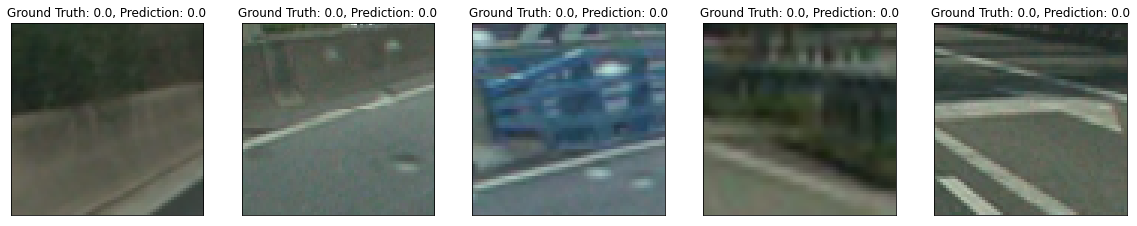

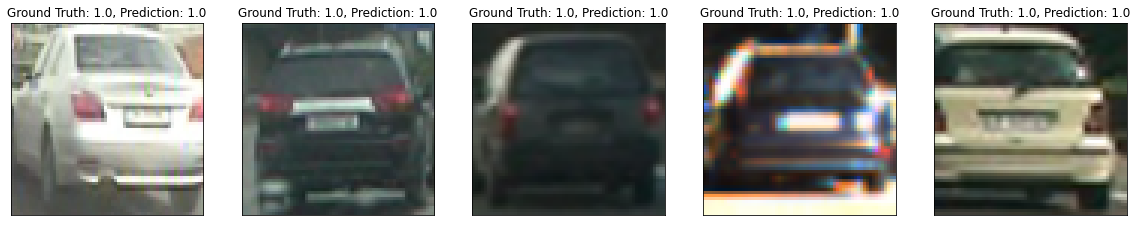

In [ ]:
# Dataset parameters
positive_negative_ratio=1
min_intersection_ratio = 0.8
number_of_positive = 800
input_shape = (64,64)

# Display Images along with predictions

fig, axes = plt.subplots(1,5)
fig.set_figheight(8)
fig.set_figwidth(20)

N = features.shape[0]

visited = list()
for i in range(5):
  while(True):
    id = randint(0,N-1)
    
    true_label = labels[id]
    if true_label == 1:
      continue

    if id in visited:
      continue

    pred = clf.predict(np.reshape(features[id],(1,-1)))
    
    axes[i].set_title("Ground Truth: {true}, Prediction: {pred}".format(true=true_label, pred=pred[0]))
    axes[i].set_xticks([]), axes[i].set_yticks([])
    axes[i].imshow(imgs[id])
    visited.append(id)
    break

plt.show()

fig, axes = plt.subplots(1,5)
fig.set_figheight(8)
fig.set_figwidth(20)

visited = list()
for i in range(5):
  while(True):
    id = randint(0,N-1)
    
    true_label = labels[id]
    if true_label == 0:
      continue

    if id in visited:
      continue

    pred = clf.predict(np.reshape(features[id],(1,-1)))
    
    axes[i].set_title("Ground Truth: {true}, Prediction: {pred}".format(true=true_label, pred=pred[0]))
    axes[i].set_xticks([]), axes[i].set_yticks([])
    axes[i].imshow(imgs[id])
    visited.append(id)
    break

plt.show()

### **Hyper-Parameter Tuning**

#### Param 1: Positive negative ratio

Best accuracy: 98.0792%
Positive to Negative Ratio: 0.25
Best recall: 97.8423%
Positive to Negative Ratio: 2
Best precision: 98.9337%
Positive to Negative Ratio: 0.25
Best Inference Execution Time: 0.0264ms
Positive to Negative Ratio: 2


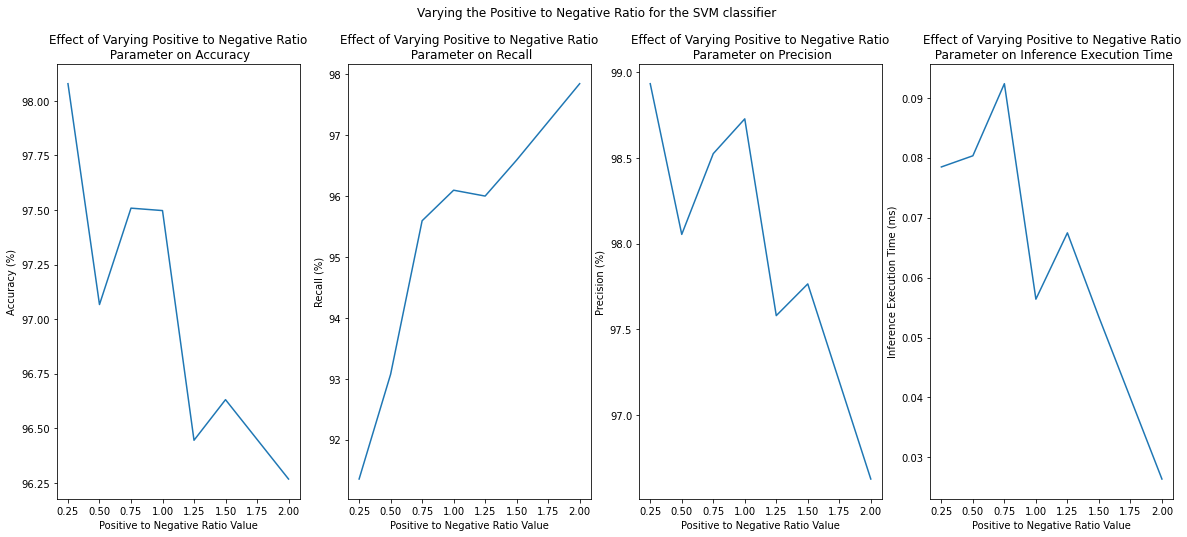

In [ ]:
import gc

# Dataset parameters
min_intersection_ratio = 0.8

number_of_positive_samples = 500

# Preprocessing parameters
orientations = 9 # number of orientation bins

input_shape = (64,64)
pixels_per_cell = (16,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = False
n_estimators = 1
C = 1
param_range = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 2]

# Random Forest params
classifier_type = 'svm'
n_estimators_random_forest = 500
criterion = 'entropy'
max_depth = None
min_samples_split = 2

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

for i, positive_negative_ratio in enumerate(param_range):
  # # Build Dataset
  # sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, number_of_positive_samples=number_of_positive_samples)

  # # Preprocess
  # features, labels = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block)

  # # CV
  # acc, rec, prec, exec = cross_validation(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  
  # V2

  # Build Dataset
  imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

  # Preprocess
  features = preprocess_images_v2(imgs, orientations, pixels_per_cell, cells_per_block)

  # CV
  acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)

  # del sequences
  del imgs
  del features
  del labels
  gc.collect()


# Display
param_name = "Positive to Negative Ratio"

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(20)
fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].plot(param_range,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].plot(param_range,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].plot(param_range,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].plot(param_range,1000*inference_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Inference Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

#### Param 2: Number of Positive Samples

Best accuracy: 97.9245%
Total Number of Samples: 4000
Best recall: 97.3563%
Total Number of Samples: 4000
Best precision: 98.4761%
Total Number of Samples: 4000
Best Inference Execution Time: 0.0347ms
Total Number of Samples: 200


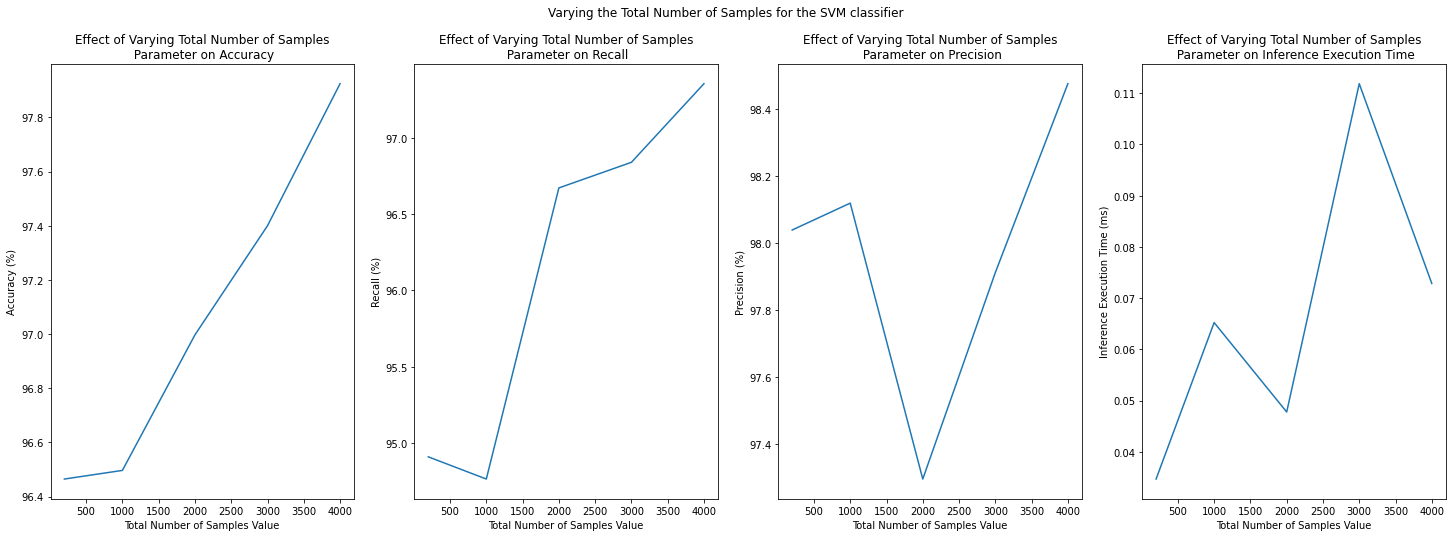

In [ ]:
import gc

# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8


# Preprocessing parameters
input_shape = (64,64)

orientations = 9 # number of orientation bins
pixels_per_cell = (16,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = False
n_estimators = 1
C = 1
param_range = [200, 1000, 2000, 3000, 4000]

# Random Forest params
classifier_type = 'svm'
n_estimators_random_forest = 500
criterion = 'entropy'
max_depth = None
min_samples_split = 2

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

for i, number_of_positive_samples in enumerate(param_range):
  # # Build Dataset
  # sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, number_of_positive_samples=number_of_positive_samples)

  # # Preprocess
  # features, labels = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block)

  # # CV
  # acc, rec, prec, exec = cross_validation(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)

  
  # V2

  # Build Dataset
  imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=int(number_of_positive_samples/2), resize_shape=input_shape)

  # Preprocess
  features = preprocess_images_v2(imgs, orientations, pixels_per_cell, cells_per_block)

  # CV
  acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  

  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)

  # del sequences
  del imgs
  del features
  del labels
  gc.collect()


# Display
param_name = "Total Number of Samples"

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].plot(param_range,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].plot(param_range,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].plot(param_range,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].plot(param_range,inference_exec_times*1000)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Inference Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

#### Param 3: Parameter C

Best accuracy: 97.6977%
C: 5
Best recall: 97.0810%
C: 0.01
Best precision: 98.5652%
C: 5
Best Inference Execution Time: 0.0411ms
C: 4


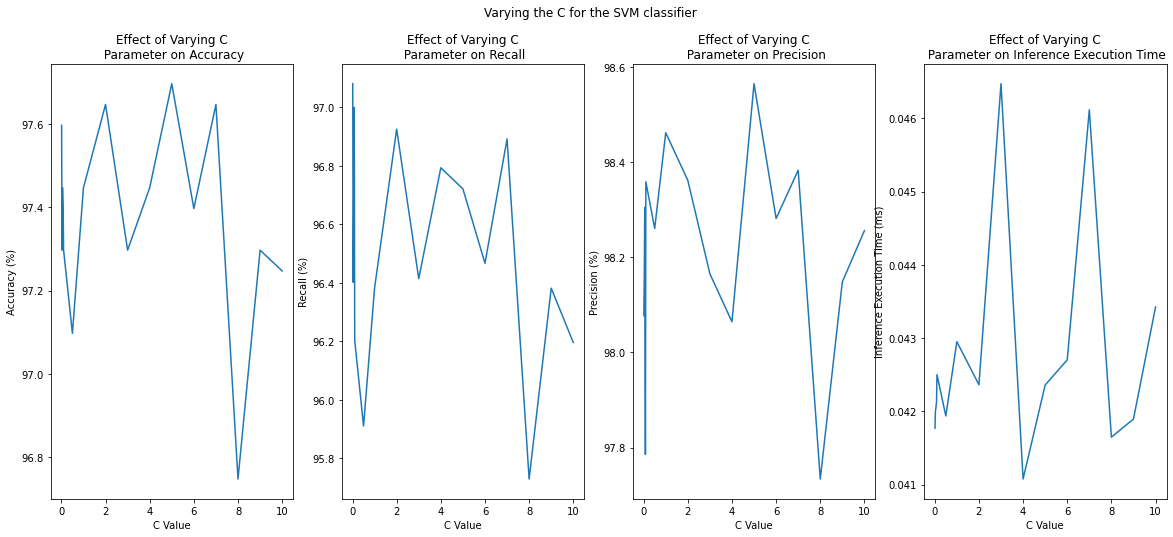

In [ ]:
import gc

# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8

number_of_positive_samples= 1000

# Preprocessing parameters
input_shape = (64,64)

orientations = 9 # number of orientation bins
pixels_per_cell = (16,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = False
n_estimators = 1
# C = 10
param_range = [0.01, 0.03,0.05, 0.08, 0.1, 0.5, 1, 2, 3, 4, 5, 6,7,8,9, 10]

# Random Forest params
classifier_type = 'svm'
n_estimators_random_forest = 500
criterion = 'entropy'
max_depth = None
min_samples_split = 2

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# # Build Dataset
# sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio)

# # Preprocess
# features, labels = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block)


# V2

# Build Dataset
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

# Preprocess
features = preprocess_images_v2(imgs, orientations, pixels_per_cell, cells_per_block)

# CV
for i, c in enumerate(param_range):
  # acc, rec, prec, exec = cross_validation(features, labels, classifier_type=classifier_type, C=c, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)

  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)

# del sequences
del imgs
del features
del labels
gc.collect()

# Display
param_name = "C"

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(20)
fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].plot(param_range,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].plot(param_range,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].plot(param_range,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].plot(param_range,inference_exec_times*1000)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Inference Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

#### Param 4: Number of Estimators in Bagging

Best accuracy: 98.2482%
Number of Estimators: 50
Best recall: 97.9894%
Number of Estimators: 80
Best precision: 98.8226%
Number of Estimators: 50
Best Inference Execution Time: 0.3479s
Number of Estimators: 10


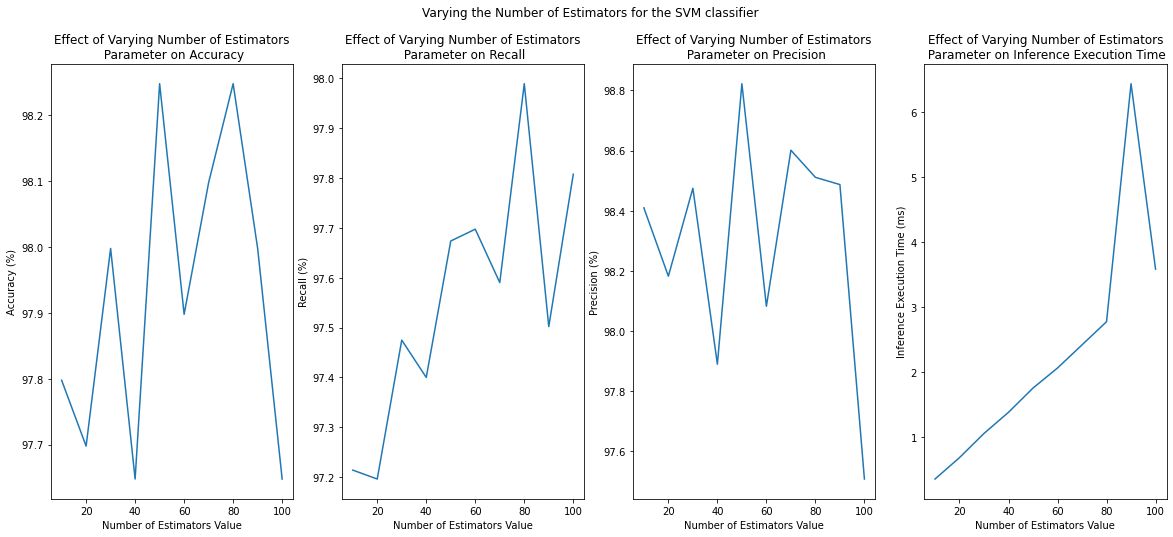

In [ ]:
import gc

# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8

number_of_positive_samples = 1000

# Preprocessing parameters
input_shape = (64,64)

orientations = 9 # number of orientation bins
pixels_per_cell = (16,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = True
#n_estimators = 1
C = 3
param_range = [10, 20, 30, 40, 50, 60, 70, 80, 90 , 100]

# Random Forest params
classifier_type = 'svm'
n_estimators_random_forest = 500
criterion = 'entropy'
max_depth = None
min_samples_split = 2

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# # Build Dataset
# sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio)

# # Preprocess
# features, labels = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block)

# Build Dataset
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

# Preprocess
features = preprocess_images_v2(imgs, orientations, pixels_per_cell, cells_per_block)

# CV
for i, n_estimators in enumerate(param_range):
  # acc, rec, prec, exec = cross_validation(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)

  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)

# del sequences
del imgs
del features
del labels
gc.collect()

# Display
param_name = "Number of Estimators"

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(20)
fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].plot(param_range,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].plot(param_range,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].plot(param_range,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].plot(param_range,1000*inference_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Inference Execution Time: {exec:.4f}s\n{param_name}: {param}".format(exec=1000*np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

###Param 5: HoG Block Shape

Best accuracy: 97.9980%
Cells Per Block: (2, 2)
Best recall: 97.7132%
Cells Per Block: (4, 4)
Best precision: 98.4988%
Cells Per Block: (2, 2)
Best Preprocessing Execution Time: 0.0000ms
Cells Per Block: (4, 4)


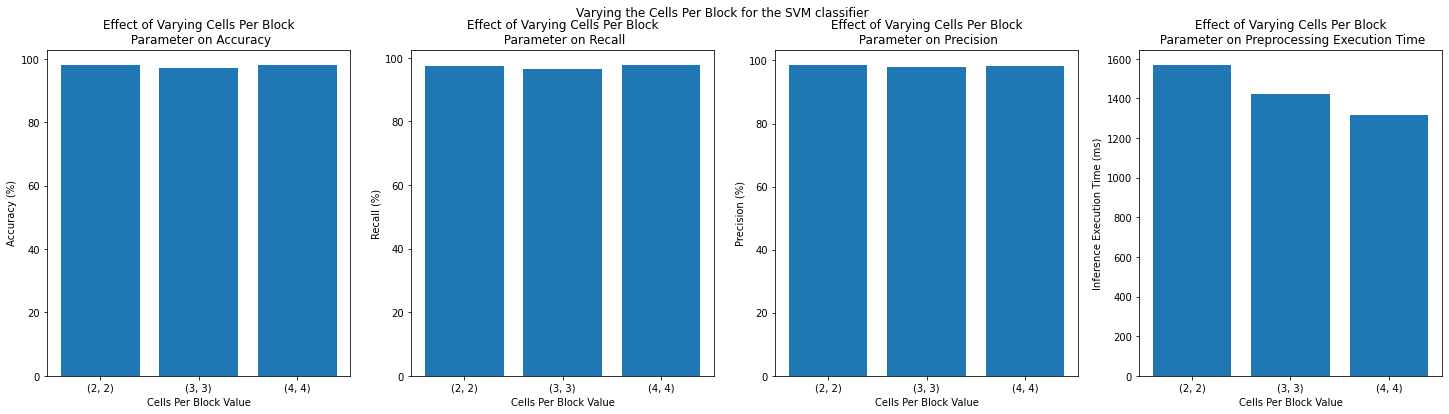

In [ ]:
import gc

# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8


# Preprocessing parameters
input_shape = (64,64)

orientations = 9 # number of orientation bins
pixels_per_cell = (16,16) # number of pixels per cell

# SVM parameters
bagging = False
n_estimators = 1
C = 3

# Random Forest params
classifier_type = 'svm'
n_estimators_random_forest = 500
criterion = 'entropy'
max_depth = None
min_samples_split = 2

param_range = [(2,2),(3,3),(4,4)]

recalls, accuracies, precisions, preprocessing_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
# sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio)
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

for i, cells_per_block in enumerate(param_range):

  # Preprocess
  # features, labels, preprocessing_exec_time = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_featurespreprocessing_time=True)
  features, preprocessing_exec_time = preprocess_images_v2(imgs, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, compute_spatial_features=compute_spatial_featurespreprocessing_time=True)

  # CV
  # acc, rec, prec, inference_exec_time = cross_validation(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion,max_depth=max_depth, min_samples_split=min_samples_split)
  acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  preprocessing_exec_times[i] = preprocessing_exec_time

  del features
  gc.collect()

# del sequences
del imgs
del labels
gc.collect()

# Display
param_name = "Cells Per Block"
param_range_str = [str(x) for x in param_range]

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].bar(param_range_str,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range_str[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].bar(param_range_str,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range_str[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].bar(param_range_str,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range_str[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].bar(param_range_str,1000*preprocessing_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Preprocessing Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Preprocessing Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(exec_times), param=param_range_str[np.argmin(preprocessing_exec_times)], param_name=param_name))

plt.show()

###Param 6: HoG Cell Shape

In [ ]:
import gc

# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8


# Preprocessing parameters
input_shape = (64,64)

orientations = 9 # number of orientation bins
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = False
n_estimators = 1
C = 3

# Random Forest params
classifier_type = 'svm'
n_estimators_random_forest = 500
criterion = 'entropy'
max_depth = None
min_samples_split = 2

param_range = [(2,2),(4,4),(8,8), (16,16)]

recalls, accuracies, precisions, preprocessing_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
# sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio)
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

for i, pixels_per_cell in enumerate(param_range):
  # Preprocess
  # features, labels, preprocessing_exec_time = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_featurespreprocessing_time=True)
  features, preprocessing_exec_time = preprocess_images_v2(imgs, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, compute_spatial_features=compute_spatial_featurespreprocessing_time=True)
  
  # CV
  # acc, rec, prec, inference_exec_time = cross_validation(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators,n_estimators_random_forest=n_estimators_random_forest, criterion=criterion,max_depth=max_depth, min_samples_split=min_samples_split)
  acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
 
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  preprocessing_exec_times[i] = preprocessing_exec_time
  
  del features
  del labels
  gc.collect()

# del sequences
del imgs
gc.collect()

# Display
param_name = "Pixels Per Cell"
param_range_str = [str(x) for x in param_range]

fig, axes = plt.subplots(1,4)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].bar(param_range_str,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range_str[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].bar(param_range_str,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range_str[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].bar(param_range_str,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range_str[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].bar(param_range_str,1000*preprocessing_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Preprocessing Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Preprocessing Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(preprocessing_exec_times), param=param_range_str[np.argmin(preprocessing_exec_times)], param_name=param_name))

plt.show()

NameError: ignored

###Param 7: Input Shape

In [ ]:
import gc

# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8


# Preprocessing parameters
# input_shape = (64,64)
# 
orientations = 9 # number of orientation bins
pixels_per_cell = (16,16) # number of pixels per cell
cells_per_block = (3,3) # number of cells per block

# SVM parameters
bagging = False
n_estimators = 1
C = 3

# Random Forest params
classifier_type = 'svm'
n_estimators_random_forest = 500
criterion = 'entropy'
max_depth = None
min_samples_split = 2

param_range = [(80,80),(80,128),(128,128),(128,192),(192,192),(192,256),(256,256)]

recalls, accuracies, precisions, preprocessing_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
# sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio)
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

for i, input_shape in enumerate(param_range):
  # Preprocess
  # features, labels, preprocessing_exec_time = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_featurespreprocessing_time=True)
  features, preprocessing_exec_time = preprocess_images_v2(imgs, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, compute_spatial_features=compute_spatial_featurespreprocessing_time=True)
 
  # CV
  # acc, rec, prec, inference_exec_time = cross_validation(features, labels,classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators,n_estimators_random_forest=n_estimators_random_forest,criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  preprocessing_exec_times[i] = preprocessing_exec_time

  del features
  del labels
  gc.collect()

# del sequences
del imgs
gc.collect()

# Display
param_name = "Input Shape"
param_range_str = [str(x) for x in param_range]

fig, axes = plt.subplots(1,4)
fig.set_figheight(10)
fig.set_figwidth(35)
fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].bar(param_range_str,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range_str[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].bar(param_range_str,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range_str[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].bar(param_range_str,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range_str[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].bar(param_range_str,1000*preprocessing_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Preprocessing Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Preprocessing Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(preprocessing_exec_times), param=param_range_str[np.argmin(preprocessing_exec_times)], param_name=param_name))

plt.show()

### Param 8: Minimum Intersection Ratio

In [ ]:
# import gc

# # Dataset parameters
# positive_negative_ratio = 1
# #min_intersection_ratio = 0.8

# number_of_positive_samples = 500

# # Preprocessing parameters
# input_shape = (64,64)

# orientations = 9 # number of orientation bins
# pixels_per_cell = (16,16) # number of pixels per cell
# cells_per_block = (4,4) # number of cells per block

# # SVM parameters
# bagging = False
# n_estimators = 1
# C = 1
# param_range = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# # Random Forest params
# classifier_type = 'svm'
# n_estimators_random_forest = 500
# criterion = 'entropy'
# max_depth = None
# min_samples_split = 2

# recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# for i, min_intersection_ratio in enumerate(param_range):
#   # Build Dataset
#   # sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, number_of_positive_samples=number_of_positive_samples)
#   imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

#   # Preprocess
#   # features, labels = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block)
#   features = preprocess_images_v2(imgs, orientations, pixels_per_cell, cells_per_block)

#   # CV
#   # acc, rec, prec, exec = cross_validation(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
#   acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)

#   recalls[i] = np.mean(rec)
#   accuracies[i] = np.mean(acc)
#   precisions[i] = np.mean(prec)
#   inference_exec_times[i] = np.mean(exec)

#   # del sequences
#   del imgs
#   del features
#   del labels
#   gc.collect()


# # Display
# param_name = "Minimum Intersection Ratio"
# fig.suptitle('Varying the {param_name} for the SVM classifier'.format(param_name=param_name))

# fig, axes = plt.subplots(1,4)
# fig.set_figheight(8)
# fig.set_figwidth(20)

# # Plot Accuracy
# axes[0].plot(param_range,accuracies)
# axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
# axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
# axes[0].set_ylabel("Accuracy (%)")
# print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# # Plot Recall
# axes[1].plot(param_range,recalls)
# axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
# axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
# axes[1].set_ylabel("Recall (%)")
# print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# # Plot Precision
# axes[2].plot(param_range,precisions)
# axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
# axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
# axes[2].set_ylabel("Precision (%)")
# print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# # Plot Inference Execution Time
# axes[3].plot(param_range,1000*inference_exec_times)
# axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
# axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
# axes[3].set_ylabel("Inference Execution Time (ms)")
# print("Best Inference Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

# plt.show()

## Random Forest Classifier Experiments

#### Param 1: Positive negative ratio

In [ ]:
import gc

# Dataset parameters
min_intersection_ratio = 0.8

number_of_positive_samples = 500

# Preprocessing parameters
input_shape = (64,64)

orientations = 9 # number of orientation bins
pixels_per_cell = (16,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = False
n_estimators = 1
C = 1

param_range = [0.25, 0.5, 0.75, 1, 1.25, 1.5, 2]

# Random Forest params
classifier_type = 'random_forest'
n_estimators_random_forest = 500
criterion = 'entropy'
max_depth = None
min_samples_split = 2

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

for i, positive_negative_ratio in enumerate(param_range):
  # Build Dataset
  # sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, number_of_positive_samples=number_of_positive_samples)
  imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

  # Preprocess
  # features, labels = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block)
  features = preprocess_images_v2(imgs, orientations, pixels_per_cell, cells_per_block)

  # CV
  # acc, rec, prec, exec = cross_validation(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
 
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)

  # del sequences
  del imgs
  del features
  del labels
  gc.collect()


# Display
param_name = "Positive to Negative Ratio"

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(20)
fig.suptitle('Varying the {param_name} for the Random Forest classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].plot(param_range,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].plot(param_range,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].plot(param_range,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].plot(param_range,1000*inference_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Inference Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

#### Param 2: Number of External Vehicle Samples

In [ ]:
import gc

# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8


# Preprocessing parameters
input_shape = (64,64)

orientations = 9 # number of orientation bins
pixels_per_cell = (16,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = False
n_estimators = 1
C = 1
param_range = [100, 500, 1000, 1500, 2000]

# Random Forest params
classifier_type = 'random_forest'
n_estimators_random_forest = 500
criterion = 'entropy'
max_depth = None
min_samples_split = 2

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

for i, number_of_positive_samples in enumerate(param_range):
  # Build Dataset
  # sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, number_of_positive_samples=number_of_positive_samples)
  imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

  # Preprocess
  # features, labels = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block)
  features = preprocess_images_v2(imgs, orientations, pixels_per_cell, cells_per_block)

  # CV
  # acc, rec, prec, exec = cross_validation(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)

  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)

  # del sequences
  del imgs
  del features
  del labels
  gc.collect()


# Display
param_name = "Number of External Vehicle Samples"

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(25)
fig.suptitle('Varying the {param_name} for the Random Forest classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].plot(param_range,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].plot(param_range,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].plot(param_range,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].plot(param_range,inference_exec_times*1000)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Inference Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

#### Param 3: Number of Estimators in Bagging

In [ ]:
import gc

# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8

number_of_positive_samples = 1000

# Preprocessing parameters
input_shape = (64,64)

orientations = 9 # number of orientation bins
pixels_per_cell = (16,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = True
#n_estimators = 1
C = 3
param_range = [10, 20, 30, 40, 50, 60, 70, 80, 90 , 100]

# Random Forest params
classifier_type = 'random_forest'
n_estimators_random_forest = 500
criterion = 'entropy'
max_depth = None
min_samples_split = 2

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
# sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio)
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

# Preprocess
# features, labels = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block)
features = preprocess_images_v2(imgs, orientations, pixels_per_cell, cells_per_block)

# CV
for i, n_estimators in enumerate(param_range):
  # acc, rec, prec, exec = cross_validation(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)

# del sequences
del imgs
del features
del labels
gc.collect()

# Display
param_name = "Number of Estimators"

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(20)
fig.suptitle('Varying the {param_name} for the Random Forest classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].plot(param_range,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].plot(param_range,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].plot(param_range,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].plot(param_range,1000*inference_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Inference Execution Time: {exec:.4f}s\n{param_name}: {param}".format(exec=1000*np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

###Param 4: HoG Block Shape

In [ ]:
import gc

# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8


# Preprocessing parameters
input_shape = (64,64)

orientations = 9 # number of orientation bins
pixels_per_cell = (8,8) # number of pixels per cell

# SVM parameters
bagging = False
n_estimators = 1
C = 3

# Random Forest params
classifier_type = 'random_forest'
n_estimators_random_forest = 500
criterion = 'entropy'
max_depth = None
min_samples_split = 2

param_range = [(2,2),(3,3),(4,4), (6,6), (8,8), (10,10)]

recalls, accuracies, precisions, preprocessing_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
# sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio)
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

for i, cells_per_block in enumerate(param_range):

  # Preprocess
  # features, labels, preprocessing_exec_time = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_featurespreprocessing_time=True)
  features, preprocessing_exec_time = preprocess_images_v2(imgs, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, compute_spatial_features=compute_spatial_featurespreprocessing_time=True)

  # CV
  # acc, rec, prec, inference_exec_time = cross_validation(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion,max_depth=max_depth, min_samples_split=min_samples_split)
  acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
 
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  preprocessing_exec_times[i] = preprocessing_exec_time

  del features
  del labels
  gc.collect()

# del sequences
del imgs
gc.collect()

# Display
param_name = "Cells Per Block"
param_range_str = [str(x) for x in param_range]

fig, axes = plt.subplots(1,4)
fig.set_figheight(4)
fig.set_figwidth(20)
fig.suptitle('Varying the {param_name} for the Random Forest classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].bar(param_range_str,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range_str[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].bar(param_range_str,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range_str[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].bar(param_range_str,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range_str[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].bar(param_range_str,1000*preprocessing_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Preprocessing Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Preprocessing Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(preprocessing_exec_times), param=param_range_str[np.argmin(preprocessing_exec_times)], param_name=param_name))

plt.show()

###Param 5: HoG Cell Shape

In [ ]:
import gc

# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8


# Preprocessing parameters
input_shape = (64,64)

orientations = 9 # number of orientation bins
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = False
n_estimators = 1
C = 3

# Random Forest params
classifier_type = 'random_forest'
n_estimators_random_forest = 500
criterion = 'entropy'
max_depth = None
min_samples_split = 2

param_range = [(2,2),(4,4),(8,8), (16,16), (20,20)]

recalls, accuracies, precisions, preprocessing_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
# sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio)
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

for i, pixels_per_cell in enumerate(param_range):
  # Preprocess
  # features, labels, preprocessing_exec_time = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block, compute_spatial_features=compute_spatial_featurespreprocessing_time=True)
  features, preprocessing_exec_time = preprocess_images_v2(imgs, orientations=orientations, pixels_per_cell=pixels_per_cell, cells_per_block=cells_per_block, compute_spatial_features=compute_spatial_features, preprocessing_time=True)

  # CV
  # acc, rec, prec, inference_exec_time = cross_validation(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators,n_estimators_random_forest=n_estimators_random_forest, criterion=criterion,max_depth=max_depth, min_samples_split=min_samples_split)
   acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)

  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  preprocessing_exec_times[i] = preprocessing_exec_time
  
  del features
  del labels
  gc.collect()

# del sequences
del imgs
gc.collect()

# Display
param_name = "Pixels Per Cell"
param_range_str = [str(x) for x in param_range]

fig, axes = plt.subplots(1,4)
fig.set_figheight(5)
fig.set_figwidth(20)
fig.suptitle('Varying the {param_name} for the Random Forest classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].bar(param_range_str,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range_str[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].bar(param_range_str,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range_str[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].bar(param_range_str,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range_str[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].bar(param_range_str,1000*preprocessing_exec_times)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Preprocessing Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Preprocessing Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(preprocessing_exec_times), param=param_range_str[np.argmin(preprocessing_exec_times)], param_name=param_name))

plt.show()

### Param 6: Minimum Intersection Ratio

In [ ]:
# import gc

# # Dataset parameters
# positive_negative_ratio = 1
# #min_intersection_ratio = 0.8

# number_of_positive_samples = 500

# # Preprocessing parameters
# input_shape = (64,64)

# orientations = 9 # number of orientation bins
# pixels_per_cell = (16,16) # number of pixels per cell
# cells_per_block = (4,4) # number of cells per block

# # SVM parameters
# bagging = False
# n_estimators = 1
# C = 1
# param_range = [0.5, 0.6, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95]

# # Random Forest params
# classifier_type = 'random_forest'
# n_estimators_random_forest = 500
# criterion = 'entropy'
# max_depth = None
# min_samples_split = 2

# recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# for i, min_intersection_ratio in enumerate(param_range):
#   # Build Dataset
#   # sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio, number_of_positive_samples=number_of_positive_samples)
#   imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

#   # Preprocess
#   # features, labels = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block)
#   features = preprocess_images_v2(imgs, orientations, pixels_per_cell, cells_per_block)

#   # CV
#   # acc, rec, prec, exec = cross_validation(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
#   acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  
#   recalls[i] = np.mean(rec)
#   accuracies[i] = np.mean(acc)
#   precisions[i] = np.mean(prec)
#   inference_exec_times[i] = np.mean(exec)

#   # del sequences
#   del imgs
#   del features
#   del labels
#   gc.collect()


# # Display
# param_name = "Minimum Intersection Ratio"

# fig, axes = plt.subplots(1,4)
# fig.set_figheight(8)
# fig.set_figwidth(20)
# fig.suptitle('Varying the {param_name} for the Random Forest classifier'.format(param_name=param_name))

# # Plot Accuracy
# axes[0].plot(param_range,accuracies)
# axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
# axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
# axes[0].set_ylabel("Accuracy (%)")
# print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# # Plot Recall
# axes[1].plot(param_range,recalls)
# axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
# axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
# axes[1].set_ylabel("Recall (%)")
# print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# # Plot Precision
# axes[2].plot(param_range,precisions)
# axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
# axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
# axes[2].set_ylabel("Precision (%)")
# print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# # Plot Inference Execution Time
# axes[3].plot(param_range,1000*inference_exec_times)
# axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
# axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
# axes[3].set_ylabel("Inference Execution Time (ms)")
# print("Best Inference Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

# plt.show()

### Param 7: Maximum Depth

In [ ]:
import gc

# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8

number_of_positive_samples= 1000

# Preprocessing parameters
input_shape = (64,64)

orientations = 9 # number of orientation bins
pixels_per_cell = (16,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = False
n_estimators = 1
C = 10

# Random Forest params
classifier_type = 'random_forest'
n_estimators_random_forest = 500
criterion = 'entropy'
# max_depth = None
min_samples_split = 2

param_range = [10, 50, 100, 250, 400, 500, 750, 1000, None] # max_depth

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
# sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio)
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

# Preprocess
# features, labels = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block)
features = preprocess_images_v2(imgs, orientations, pixels_per_cell, cells_per_block)

# CV
for i, max_depth in enumerate(param_range):
  # acc, rec, prec, exec = cross_validation(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  
  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)

# del sequences
del imgs
del features
del labels
gc.collect()

# Display
param_name = "Max Depth"

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(20)
fig.suptitle('Varying the {param_name} for the Random Forest classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].plot(param_range,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].plot(param_range,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].plot(param_range,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].plot(param_range,inference_exec_times*1000)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Inference Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()

### Param 8: Minimum Samples Required to Split a Node

In [ ]:
import gc

# Dataset parameters
positive_negative_ratio = 1
min_intersection_ratio = 0.8

number_of_positive_samples= 1000

# Preprocessing parameters
input_shape = (64,64)

orientations = 9 # number of orientation bins
pixels_per_cell = (16,16) # number of pixels per cell
cells_per_block = (4,4) # number of cells per block

# SVM parameters
bagging = False
n_estimators = 1
C = 10

# Random Forest params
classifier_type = 'random_forest'
n_estimators_random_forest = 500
criterion = 'entropy'
max_depth = None
# min_samples_split = 2

param_range = [1,2,3,5,8,10,15,20,30] # min_samples_split

recalls, accuracies, precisions, inference_exec_times = np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range)), np.zeros(len(param_range))

# Build Dataset
# sequences = build_dataset(positive_negative_ratio=positive_negative_ratio, min_intersection_ratio=min_intersection_ratio)
imgs, labels = build_dataset_v2(positive_negative_ratio=positive_negative_ratio, number_of_positive_samples=number_of_positive_samples, resize_shape=input_shape)

# Preprocess
# features, labels = preprocess_sequences(sequences, input_shape, orientations, pixels_per_cell, cells_per_block)
features = preprocess_images_v2(imgs, orientations, pixels_per_cell, cells_per_block)

# CV
for i, min_samples_split in enumerate(param_range):
  # acc, rec, prec, exec = cross_validation(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)
  acc, rec, prec, exec = cross_validation_v2(features, labels, classifier_type=classifier_type, C=C, bagging=bagging, n_estimators=n_estimators, n_estimators_random_forest=n_estimators_random_forest, criterion=criterion, max_depth=max_depth, min_samples_split=min_samples_split)

  recalls[i] = np.mean(rec)
  accuracies[i] = np.mean(acc)
  precisions[i] = np.mean(prec)
  inference_exec_times[i] = np.mean(exec)

# del sequences
del imgs
del features
del labels
gc.collect()

# Display
param_name = "Minimum Samples to Split"

fig, axes = plt.subplots(1,4)
fig.set_figheight(8)
fig.set_figwidth(20)
fig.suptitle('Varying the {param_name} for the Random Forest classifier'.format(param_name=param_name))

# Plot Accuracy
axes[0].plot(param_range,accuracies)
axes[0].set_title("Effect of Varying {param_name}\n Parameter on Accuracy".format(param_name=param_name))
axes[0].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[0].set_ylabel("Accuracy (%)")
print("Best accuracy: {acc:.4f}%\n{param_name}: {param}".format(acc=np.max(accuracies), param=param_range[np.argmax(accuracies)], param_name=param_name))

# Plot Recall
axes[1].plot(param_range,recalls)
axes[1].set_title("Effect of Varying {param_name}\n Parameter on Recall".format(param_name=param_name))
axes[1].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[1].set_ylabel("Recall (%)")
print("Best recall: {rec:.4f}%\n{param_name}: {param}".format(rec=np.max(recalls), param=param_range[np.argmax(recalls)],param_name=param_name))

# Plot Precision
axes[2].plot(param_range,precisions)
axes[2].set_title("Effect of Varying {param_name}\n Parameter on Precision".format(param_name=param_name))
axes[2].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[2].set_ylabel("Precision (%)")
print("Best precision: {prec:.4f}%\n{param_name}: {param}".format(prec=np.max(precisions), param=param_range[np.argmax(precisions)], param_name=param_name))

# Plot Inference Execution Time
axes[3].plot(param_range,inference_exec_times*1000)
axes[3].set_title("Effect of Varying {param_name}\n Parameter on Inference Execution Time".format(param_name=param_name))
axes[3].set_xlabel("{param_name} Value".format(param_name=param_name))
axes[3].set_ylabel("Inference Execution Time (ms)")
print("Best Inference Execution Time: {exec:.4f}ms\n{param_name}: {param}".format(exec=1000*np.min(inference_exec_times), param=param_range[np.argmin(inference_exec_times)], param_name=param_name))

plt.show()